In [49]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams, LLMTestCase
from deepeval.dataset import EvaluationDataset
from deepeval import evaluate
from deepeval.models import AzureOpenAIModel

# 1. Preprocessing

In [10]:
df_plot = pd.read_csv("data/wiki_movie_plots_deduped.csv")
df_plot = df_plot[df_plot['Origin/Ethnicity']=='American']

In [11]:
df_plot['num_newlines'] = df_plot["Plot"].str.count("\n")
df_plot["len_ending"] = df_plot["Plot"].str.split("\n").map(lambda l: len(l[-1].split(" ")))

In [12]:
# we want movies that have detailed wiki plots and with a decently long ending paragraph
df_plot = df_plot[(df_plot['num_newlines'].rank(pct=True)>=0.75) & (df_plot["len_ending"].rank(pct=True)>=0.75)]

In [13]:
df_plot = df_plot.sort_values("Release Year", ascending=False)

In [14]:
df_plot['plot_without_ending'] = df_plot["Plot"].str.split("\n").map(lambda l: "\n".join(l[:-1]))
df_plot['ending'] = df_plot["Plot"].str.split("\n").map(lambda l: l[-1])

In [15]:
# RECENT MOVIES (2008 to 2017)
df_plot = df_plot[df_plot['Release Year']>=2008]

In [91]:
df_plot.to_csv("data/wiki_movie_plots_base.csv")

# 2. G-Eval assessment of original endings

In [29]:
# For Azure OpenAI
azure_model = AzureOpenAIModel(
    model_name="gpt-4o",
    temperature=0.0,
    top_p=0
)

In [30]:
# define metrics
df_criteria = pd.read_csv("data/movie_ending_criteria.csv")
df_criteria['evaluation_steps'] = df_criteria['evaluation_steps'].str.split("\n")
df_criteria = df_criteria.set_index("criteria")['evaluation_steps']

evaluation_params = [LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT]
metrics = [
    GEval(
        name=criterion,
        evaluation_steps=df_criteria.loc[criterion],
        evaluation_params=evaluation_params,
        model=azure_model,
        # verbose_mode=True,
        async_mode=False
    ) for criterion in df_criteria.index
]

In [31]:
# create evaluation dataset
test_cases = [
    LLMTestCase(
            input = df_plot.iloc[k]['plot_without_ending'],
            actual_output = df_plot.iloc[k]['ending']
        ) for k in range(df_plot.shape[0])
]

for k in range(df_plot.shape[0]):
    test_cases[k].name = str(df_plot.iloc[k]["Title"])
evaluation_dataset = EvaluationDataset(test_cases=test_cases)

In [32]:
# run evaluation
evaluation_results = evaluate(
    evaluation_dataset,
    metrics,TR
    ignore_errors=True,
    run_async=False,
    write_cache=False
)

✨ You're running DeepEval's latest Closure & Resolution ✅ (GEval) Metric! (using Azure OpenAI, strict=False, 
async_mode=False)...

✨ You're running DeepEval's latest Emotional Impact 🎭 (GEval) Metric! (using Azure OpenAI, strict=False, 
async_mode=False)...

✨ You're running DeepEval's latest Narrative Coherence & Logic 🔗 (GEval) Metric! (using Azure OpenAI, 
strict=False, async_mode=False)...

✨ You're running DeepEval's latest Thematic Payoff 🎯 (GEval) Metric! (using Azure OpenAI, strict=False, 
async_mode=False)...

✨ You're running DeepEval's latest Surprise Factor 🤯 (GEval) Metric! (using Azure OpenAI, strict=False, 
async_mode=False)...

✨ You're running DeepEval's latest Genre Alignment 🎞 (GEval) Metric! (using Azure OpenAI, strict=False, 
async_mode=False)...

Evaluating 108 test case(s) sequentially: |████████████████|100% (108/108) [Time Taken: 24:01, 13.35s/test case]



Metrics Summary

  - ✅ Closure & Resolution ✅ (GEval) (score: 1.0, threshold: 0.5, strict: False, evaluation model: Azure OpenAI, reason: The main conflict of Aristide Leonides' murder is resolved with Josephine revealed as the killer. Subplots, including suspicions cast among various family members, are addressed. The ending, although tragic, provides complete closure with Edith's sacrificial act and the deaths of Edith and Josephine., error: None)
  - ✅ Emotional Impact 🎭 (GEval) (score: 0.8, threshold: 0.5, strict: False, evaluation model: Azure OpenAI, reason: The intended emotional response is shock and sadness. There's a strong character investment due to Charles's romantic involvement with Sophia and the intrigue generated by the intricate family dynamics. The ending effectively elicits emotions as the truth about Josephine and Edith's sacrifice feels earned. The shock of Edith’s resolve and Josephine’s cruelty strongly impacts the audience, fulfilling emotional criteria well 

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

In [33]:
pickle.dump(
    evaluation_results,
    open("output/initial_evaluation_results.p", "wb"))

In [34]:
df_summary = pd.concat([pd.DataFrame([(x.name, y.name, y.score, y.reason) for y in x.metrics_data]) for x in evaluation_results.test_results], axis=0)
df_summary.columns = ['title', 'criterion', 'score', 'reason']
df_summary.to_csv("output/initial_evaluation_df.csv", index=False)

In [39]:
df_pivot = pd.pivot_table(
    df_summary,
    values='score', 
    index='title',
    columns='criterion'
)

In [63]:
df_score = df_pivot.mean(axis=1).sort_values(ascending=False).reset_index()
genre_dict = df_plot.set_index("Title")["Genre"].to_dict()

In [66]:
df_score['genre'] = df_score['title'].map(genre_dict)

/var/folders/1c/bffjn24x1dv9skkx4w8zbclw0000gn/T/ipykernel_3690/85883968.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_pivot.hist(bins=50, ax=plt.gca());
findfont: Font family 'Apple Color Emoji' not found.
findfont: Font family 'Apple Color Emoji' not found.
findfont: Font family 'Apple Color Emoji' not found.
findfont: Font family 'Apple Color Emoji' not found.
findfont: Font family 'Apple Color Emoji' not found.
findfont: Font family 'Apple Color Emoji' not found.
findfont: Font family 'Apple Color Emoji' not found.
findfont: Font family 'Apple Color Emoji' not found.
findfont: Font family 'Apple Color Emoji' not found.
/Users/piogabriellecalderon/Documents/code/optimize_endings/optimize_endings_env/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
findfont: Font family 'Apple Color Emoji' not found.
findf

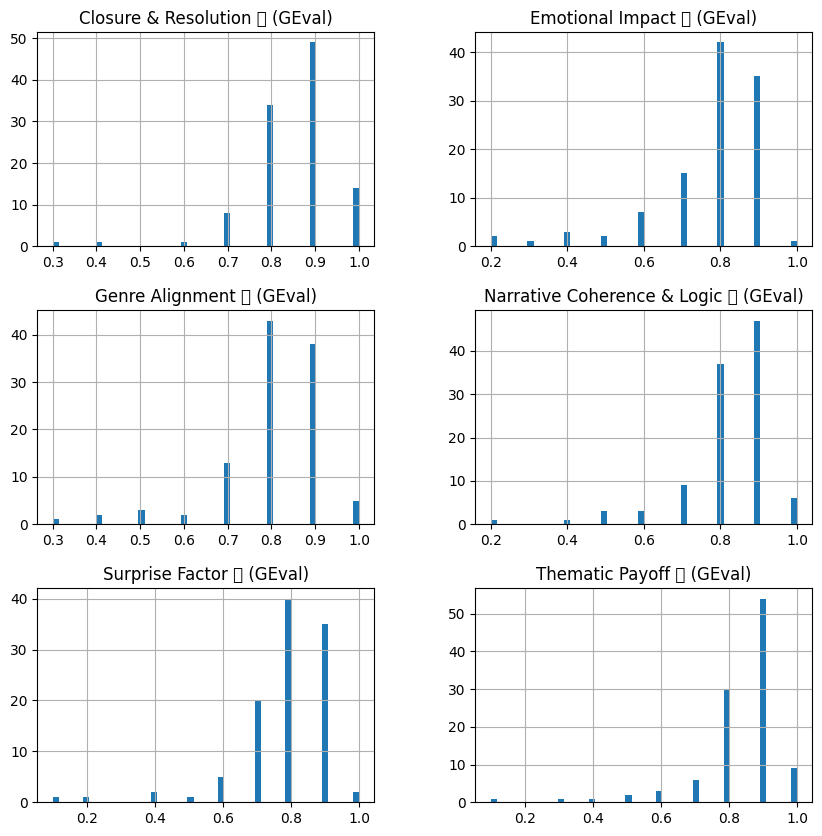

In [120]:
plt.figure(figsize=(10,10))
df_pivot.hist(bins=50, ax=plt.gca());